In [4]:
!poetry run python -m pip install torchsde


[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!poetry run python -m pip -V

pip 22.2 from /home/gflan/.cache/pypoetry/virtualenvs/ancufi--w791oWn-py3.8/lib/python3.8/site-packages/pip (python 3.8)


In [5]:
import torch
from torch import nn
import torchsde
import numpy as np

import os
import sys
import tqdm

In [6]:
is_cuda = torch.cuda.is_available()
# is_cuda = False
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

Nuestro modelo, drift y difussion son redes neuronales que vamos a entrenar.

In [339]:
class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [
            torch.nn.Linear(in_size, mlp_size),
            torch.nn.LeakyReLU(0.01),
#             torch.nn.Tanh()
        ]
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            model.append(torch.nn.Tanh())
        model.append(torch.nn.Linear(mlp_size, out_size))
        if tanh:
            model.append(torch.nn.Tanh())
        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

In [340]:
class SDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'

    def __init__(self, state_size=1, batch_size=32, mlp_size=100, num_layers=3, tanh=False):
        super().__init__()
        
        in_size = 2 * state_size # S(t) y t
        out_size = state_size # drift o difusion final
        mu_sigma_args = dict(
            in_size=in_size,
            out_size=out_size,
            mlp_size=mlp_size, 
            num_layers=num_layers,
            tanh=tanh
        )
        self.mu = MLP(**mu_sigma_args)
        self.sigma = MLP(**mu_sigma_args)

    # Drift
    def f(self, t, y):
        # armar un tensor de batch_size componentes con el tiempo t
        batch_t = torch.full((batch_size,1), t.item())
        # forward prop de la f
        # mu([
        #     (y_0, t), 
        #     (y_1, t),
        #     .. 
        #     (y_n, t) <--- n = batch_size
        # ]) 
        return self.mu(torch.cat((y, batch_t), dim=1))  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        # idem mu
        batch_t = torch.full((batch_size,1), t.item())
        return self.sigma(torch.cat((y, batch_t), dim=1))

# sde = SDE().to(device)

Browniano Geométrico como benchmark conocido

In [81]:
class BGM_SDE(nn.Module):

    def __init__(self, mu, sigma):
        super().__init__()
        self.noise_type="diagonal"
        self.sde_type = "ito"

        self.mu = mu
        self.sigma = sigma

    def f(self, t, y):
        return self.mu * y

    def g(self, t, y):
        return self.sigma * y

## Earth Mover's Distance

In [82]:
def emd(p, q, steps=11):
  quantiles = torch.linspace(0, 1, steps=steps) 
  # tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000, 1.0000])
  p_q = torch.quantile(p, quantiles, dim=0, keepdim=True) # aproximacion numérica
  q_q = torch.quantile(q, quantiles, dim=0, keepdim=True)

  return torch.abs(p_q - q_q).sum().div(steps)

In [211]:
# Dos normales con misma varianza y un shift de una unidad, emd ~= 1 

p = torch.normal(mean=1, std=1, size=(300,), requires_grad=True)
q = torch.normal(mean=0, std=1, size=(300,), requires_grad=True)

res = emd(p, q, steps=11)
print(res)

del res, p, q

tensor(1.0504, grad_fn=<DivBackward0>)


### TorchSDE

In [278]:
# y0 dimension (batch_size, state_size) da el valor inicial de la SDE en tiempo ts[0]
batch_size, state_size, brownian_size = 200, 1, 2
y0 = torch.randn(batch_size, state_size, device=device) + 3
ts = torch.linspace(0, 1, brownian_size)

sde = SDE(state_size=state_size, batch_size=batch_size, mlp_size=100, num_layers=3, tanh=False).to(device)

bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)

with torch.no_grad():
    # Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
    # ys will have shape (t_size, batch_size, state_size)
    ys = torchsde.sdeint(sde, y0, ts, method="euler", bm=bm)        
    ys_bgm = torchsde.sdeint(BGM_SDE(mu=5, sigma=1), y0, ts, method="euler", bm=bm)    

In [185]:
print(ys.shape) # (brownian_size, batch_size, state_size)

ys_bgm[-1,:,0] # final del browniano, todo el batch, primer (unico) estado

torch.Size([51, 200, 1])


tensor([ 131.6433, 1513.5986, 1382.3842,  312.5243, 1176.4165, 2665.2014,
         588.3683,  116.3098,   59.6227,  989.2415,  152.4067,  195.4709,
          37.5701,  388.2460,  190.8625,  276.2303,  240.4867,  107.3762,
         156.0478,   36.2896,  563.5885,   68.7631,  231.2793,   81.9120,
          70.8166,  245.1088,  232.9114,   95.7193,   97.7503,   72.2374,
         764.7294,  161.3344, 1121.5210, 1052.8916, 1731.7841,  230.1408,
        3018.8347,  125.9547, 2288.4651,  227.8098,  504.6454,  188.0315,
          52.8953,   84.8800,  171.9406, 1024.6031,  223.3371,   87.5843,
         250.8811,  188.9406,  250.4645,  339.3933,  142.1904, 2109.2192,
         235.8447,  248.7401,  327.3354,  102.0925,  582.2659,  419.4371,
          95.6439,  610.9681,  179.8131,  606.0002,  679.7093,   80.6000,
         331.1133,  241.2989,  168.8495,  365.4901,  783.5859,  477.3808,
         108.9219,  909.2392,   48.4304,  696.1393,  434.2520,  308.0728,
         870.9852,  173.3569,   88.740

<AxesSubplot:ylabel='Frequency'>

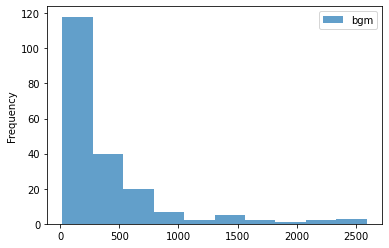

In [341]:
import pandas as pd
pd.DataFrame(
    {
        "bgm": ys_bgm[-1,:,0].numpy(),
#         "sde": ys[-1,:,0].numpy()
    }
).plot.hist(alpha=0.7, bins=10)

In [145]:
emd(ys[-1,:,0], ys_bgm[-1,:,0])

tensor(2.7549)

In [23]:
torchsde.sdeint?

In [ ]:
steps = 500
ts = torch.linspace(0, 1, 2)
batch_size = 200

a, b = .5, .2 # µ y σ del BGM
sde = SDE(state_size=state_size, batch_size=batch_size, mlp_size=100, num_layers=3, tanh=True).to(device)
gbm = BGM_SDE(mu=a, sigma=b).to(device)
opt = torch.optim.SGD(sde.parameters(), lr=0.1, momentum=0.9)

losses = []
best_st = best_rt =  None 
best_loss = np.inf

y0 = torch.full((batch_size, state_size), 140)

trange = tqdm.tqdm(range(steps))
for step in trange:
    # Nuevo batch, grad en 0
    opt.zero_grad()

    #y0 = 10*torch.randn(batch_size, state_size, device=device) + 140
    
    
    # generar traza del GBM
    bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
    st = torchsde.sdeint(gbm, y0, ts, method='euler', bm=bm)
    
    # generar traza de nuestra SDE
    bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
    rt = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm) # (brownian_size, batch_size, state_size)?

    # agarrar las ultimas para comparar
    wasserstein_loss = emd(st[-1,:,0], rt[-1,:,0])
    
    if best_loss > wasserstein_loss.item():
        best_st = st[-1,:,0].detach().numpy() 
        best_rt = rt[-1,:,0].detach().numpy()
        best_loss = wasserstein_loss.item()
    
    losses.append(wasserstein_loss.item())
    # Computar grad
    wasserstein_loss.backward()
    # Optimizar sobre el batch
    opt.step()


  0%|▍                                                                                                                | 2/500 [00:10<42:12,  5.09s/it]

<AxesSubplot:>

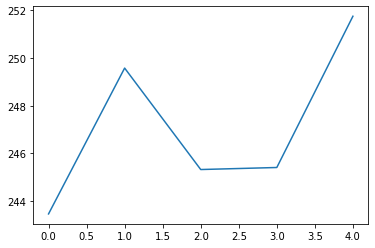

In [348]:
pd.Series(losses).plot()

<AxesSubplot:>

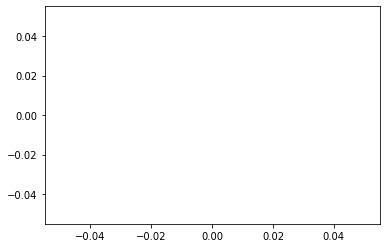

In [344]:
pd.Series(losses).rolling(15).mean().plot()

In [345]:
best_loss

244.7371063232422

<AxesSubplot:ylabel='Frequency'>

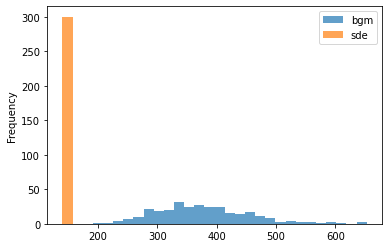

In [349]:
pd.DataFrame(
    {
        "bgm": best_st,
        "sde": best_rt
    }
).plot.hist(alpha=0.7, bins=30)

In [257]:
sde.f = lambda x,y: 0*x*y

In [338]:
list(sde.mu.parameters())[0], list(sde.sigma.parameters())[0], 

(Parameter containing:
 tensor([[ 0.4770,  0.4992],
         [ 0.4418, -0.6174],
         [-0.5773, -0.1682],
         [ 0.2818, -0.1414],
         [-0.0727,  0.1058],
         [ 0.5735,  0.4675],
         [ 0.3570,  0.3890],
         [ 0.6097,  0.0633],
         [ 0.5913, -0.2364],
         [ 0.3688, -0.1900],
         [-0.5841,  0.6386],
         [-0.1114,  0.4189],
         [-0.1001,  0.3157],
         [ 0.3094,  0.2775],
         [-0.2132,  0.0758],
         [ 0.0747, -0.5870],
         [ 0.5522, -0.6105],
         [ 0.2443, -0.6280],
         [-0.1729,  0.6690],
         [-0.2144,  0.6027],
         [-0.6978,  0.2279],
         [-0.3065,  0.1819],
         [ 0.2491, -0.0187],
         [ 0.2758, -0.6417],
         [ 0.2163, -0.6754],
         [ 0.3433, -0.4769],
         [-0.3953,  0.4141],
         [-0.3352,  0.1795],
         [-0.7030,  0.4744],
         [-0.6785,  0.2800],
         [ 0.1643, -0.5496],
         [-0.1172,  0.5941],
         [ 0.3533, -0.3728],
         [-0.2254,  

In [227]:
pd.Series(best_st).describe()

count    3.000000e+02
mean     7.378558e+00
std      5.239780e+01
min      4.224438e-09
25%      1.231473e-04
50%      3.103486e-03
75%      1.936082e-01
max      7.001907e+02
dtype: float64

In [193]:
sts = rts = np.array([])
with torch.no_grad():
    for i in tqdm.tqdm(range(20)):
        y0 = torch.randn(batch_size, state_size, device=device) + 140
        bm_ = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        st = torchsde.sdeint(gbm, y0, ts, method='euler', bm=bm)
        bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        rt = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm) # (brownian_size, batch_size, state_size)?
        sts = np.append(sts, st[-1:, :, :][0,:,0].detach().numpy())
        rts = np.append(rts, rt[-1:, :, :][0,:,0].detach().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:53<00:00,  2.66s/it]


<AxesSubplot:ylabel='Frequency'>

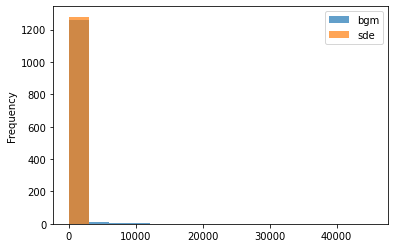

In [195]:
pd.DataFrame(
    {
        "bgm": sts,
        "sde": rts
    }
).plot.hist(alpha=0.7, bins=15)

In [349]:
def price_func(s, k):
  # s y k vectores
  return max(s-k, 0)

In [357]:
best_loss

0.025777267292141914